# Experiment POC OBI
> Can we get better by training on our assumptions?

In [ ]:
# default_exp poc_online_bayesian_inference

In [ ]:
# hide
import blackhc.project.script

Import modules and functions were are going to use.

In [ ]:
# exports

import dataclasses
import traceback
from dataclasses import dataclass
from typing import Type, Union

import torch
import torch.utils.data
from blackhc.project import is_run_from_ipython
from blackhc.project.experiment import embedded_experiments
from torch.utils.data import Dataset

import wandb

from batchbald_redux.active_learning import ActiveLearningData, RandomFixedLengthSampler
from batchbald_redux.black_box_model_training import evaluate_old, train
from batchbald_redux.dataset_operations import NamedDataset
from batchbald_redux.di import DependencyInjection
from batchbald_redux.experiment_logging import asclassdict, init_wandb, log2wandb
from batchbald_redux.fast_mnist import FastMNIST
from batchbald_redux.model_optimizer_factory import ModelOptimizerFactory
from batchbald_redux.models import MnistOptimizerFactory
from batchbald_redux.online_bayesian_inference import evaluate_online_bayesian_inference

In [ ]:
# exports

# From the BatchBALD Repo
from batchbald_redux.train_eval_model import TrainEvalModel

In [ ]:
# exports

from blackhc.progress_bar import create_progress_bar
from toma import toma


def compute_entropy_from_probs(probs_N_K_C: torch.Tensor) -> torch.Tensor:
    N, K, C = probs_N_K_C.shape

    entropies_N = torch.empty(N, dtype=torch.double)

    pbar = create_progress_bar(N, tqdm_args=dict(desc="Entropy", leave=False))
    pbar.start()

    @toma.execute.chunked(probs_N_K_C, 1024)
    def compute(probs_n_K_C, start: int, end: int):
        mean_probs_n_C = probs_n_K_C.mean(dim=1)
        nats_n_C = mean_probs_n_C * torch.log(mean_probs_n_C)
        nats_n_C[mean_probs_n_C == 0] = 0.0

        entropies_N[start:end].copy_(-torch.sum(nats_n_C, dim=1))
        pbar.update(end - start)

    pbar.finish()

    return entropies_N

In [ ]:
train_predictions = torch.load("./data/mnist_train_predictions.pt", map_location="cpu")
train_entropies = compute_entropy_from_probs(train_predictions[:, None, :])

Entropy:   0%|          | 0/60000 [00:00<?, ?it/s]

In [ ]:
from matplotlib import pyplot as plt

(array([55951.,  1227.,   635.,   386.,   241.,   206.,   130.,   117.,
          118.,    74.]),
 array([0.  , 0.02, 0.04, 0.06, 0.08, 0.1 , 0.12, 0.14, 0.16, 0.18, 0.2 ]),
 <BarContainer object of 10 artists>)

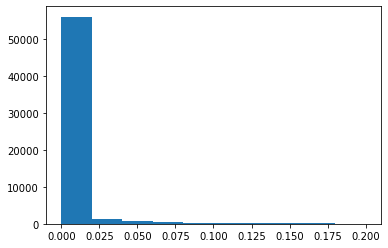

In [ ]:
plt.hist(train_entropies.cpu().numpy(), range=[0, 0.2])

In [ ]:
60000 - len(torch.nonzero(train_entropies < 0.01, as_tuple=True)[0].numpy())

5678

In [ ]:
import numpy as np

In [ ]:
# draw random samples

initial_training_set = [
    51348,
    49110,
    8222,
    28130,
    13484,
    47685,
    3938,
    59930,
    49196,
    19427,
    4601,
    49922,
    45635,
    35684,
    3579,
    7621,
    8465,
    33959,
    27521,
    27015,
]


remaining_samples = [i for i in range(60000) if i not in initial_training_set]
random_samples = np.random.choice(remaining_samples, size=80, replace=False)

initial_training_set + list(random_samples)

[51348,
 49110,
 8222,
 28130,
 13484,
 47685,
 3938,
 59930,
 49196,
 19427,
 4601,
 49922,
 45635,
 35684,
 3579,
 7621,
 8465,
 33959,
 27521,
 27015,
 14546,
 56672,
 29175,
 34788,
 8131,
 26332,
 38192,
 21892,
 39029,
 38998,
 5055,
 59421,
 38657,
 56902,
 12450,
 24639,
 40834,
 49727,
 36103,
 9254,
 9245,
 58379,
 23120,
 33276,
 4809,
 1912,
 21893,
 40110,
 13327,
 12976,
 32620,
 33379,
 46791,
 54018,
 56012,
 14950,
 23198,
 23621,
 8800,
 13812,
 39580,
 51209,
 890,
 47684,
 52758,
 53629,
 1215,
 31729,
 24465,
 50917,
 48575,
 47113,
 20236,
 39311,
 25944,
 43811,
 37921,
 6902,
 321,
 49988,
 9436,
 33907,
 56920,
 13604,
 29309,
 14098,
 22260,
 40723,
 27635,
 36611,
 57194,
 44682,
 55813,
 29089,
 23673,
 55498,
 636,
 32250,
 33342,
 34457]

In [ ]:
# exports

# Rerun from 2022/04/15

training_set_90 = [
    46377,
    44390,
    7485,
    25450,
    12220,
    43112,
    3612,
    54256,
    44467,
    17555,
    4218,
    45101,
    41296,
    32261,
    3281,
    6944,
    7701,
    30692,
    24891,
    24436,
    17776,
    36852,
    26891,
    17001,
    44414,
    23050,
    30884,
    41516,
    8897,
    34608,
    11721,
    13127,
    9870,
    39700,
    13985,
    9608,
    17808,
    23028,
    3494,
    10210,
    42384,
    31742,
    17100,
    46530,
    26733,
    4762,
    14113,
    20798,
    28388,
    42973,
    37347,
    55042,
    41295,
    28310,
    19280,
    18501,
    274,
    11208,
    13335,
    24440,
    49493,
    58129,
    56210,
    40766,
    13318,
    50040,
    18408,
    7255,
    15494,
    7168,
    9472,
    14845,
    14096,
    26072,
    35944,
    34836,
    12655,
    991,
    38577,
    47322,
    45212,
    16286,
    5308,
    38182,
    31624,
    12702,
    30861,
    46320,
    36408,
    49841,
    33426,
    57527,
    3273,
    24740,
    39627,
    22199,
    19362,
    42136,
    41965,
    43095,
]

training_set_90[:20] = [
    51348,
    49110,
    8222,
    28130,
    13484,
    47685,
    3938,
    59930,
    49196,
    19427,
    4601,
    49922,
    45635,
    35684,
    3579,
    7621,
    8465,
    33959,
    27521,
    27015,
]

training_set_random = [
    51348,
    49110,
    8222,
    28130,
    13484,
    47685,
    3938,
    59930,
    49196,
    19427,
    4601,
    49922,
    45635,
    35684,
    3579,
    7621,
    8465,
    33959,
    27521,
    27015,
    14546,
    56672,
    29175,
    34788,
    8131,
    26332,
    38192,
    21892,
    39029,
    38998,
    5055,
    59421,
    38657,
    56902,
    12450,
    24639,
    40834,
    49727,
    36103,
    9254,
    9245,
    58379,
    23120,
    33276,
    4809,
    1912,
    21893,
    40110,
    13327,
    12976,
    32620,
    33379,
    46791,
    54018,
    56012,
    14950,
    23198,
    23621,
    8800,
    13812,
    39580,
    51209,
    890,
    47684,
    52758,
    53629,
    1215,
    31729,
    24465,
    50917,
    48575,
    47113,
    20236,
    39311,
    25944,
    43811,
    37921,
    6902,
    321,
    49988,
    9436,
    33907,
    56920,
    13604,
    29309,
    14098,
    22260,
    40723,
    27635,
    36611,
    57194,
    44682,
    55813,
    29089,
    23673,
    55498,
    636,
    32250,
    33342,
    34457,
]


@dataclass
class Experiment:
    seed: int = 1337
    num_pool_samples: int = 20
    num_validation_samples: int = 20
    num_training_samples: int = 1
    num_patience_epochs: int = 5 * 4
    max_training_epochs: int = 30 * 4
    training_batch_size: int = 64
    device: str = "cuda"
    validation_set_size: int = 1024
    min_samples_per_epoch: int = 1024
    model_optimizer_factory: Type[ModelOptimizerFactory] = MnistOptimizerFactory
    max_obi_steps: int = 10
    num_samples_list: int = (100, 1000, 10000)
    up_factor: int = 2
    num_trials: int = 5
    acquisition_size: int = 5
    random_acquisition: bool = False

    def load_dataset(self, training_set_indices) -> (ActiveLearningData, Dataset, Dataset):
        train_dataset = NamedDataset(
            FastMNIST("data", train=True, download=True, device=self.device), "FastMNIST (train)"
        )

        train_predictions = torch.load("./data/mnist_train_predictions.pt", map_location=self.device)

        train_dataset = train_dataset.override_targets(targets=train_predictions.argmax(dim=1))

        active_learning_data = ActiveLearningData(train_dataset)

        active_learning_data.acquire_base_indices(training_set_indices[:20])

        active_learning_data_validation_set = ActiveLearningData(train_dataset)
        active_learning_data_validation_set.acquire_base_indices(training_set_indices)

        validation_dataset = active_learning_data_validation_set.extract_dataset_from_pool(self.validation_set_size)
        validation_dataset = NamedDataset(
            validation_dataset, f"FastMNIST (validation, {len(validation_dataset)} samples)"
        )

        test_dataset = FastMNIST("data", train=False, device=self.device)
        test_dataset = NamedDataset(test_dataset, f"FastMNIST (test, {len(test_dataset)} samples)")

        return active_learning_data, validation_dataset, test_dataset, training_set_indices[:20]

    # Simple Dependency Injection
    def create_train_eval_model(self, runtime_config) -> TrainEvalModel:
        config = {**vars(self), **runtime_config}
        di = DependencyInjection(config, [])
        return di.create_dataclass_type(self.train_eval_model)

    def run(self, store):
        init_wandb(self)

        training_set_indices = training_set_random if self.random_acquisition else training_set_90

        torch.manual_seed(self.seed)

        # Active Learning setup
        active_learning_data, validation_dataset, test_dataset, initial_training_set_indices = self.load_dataset(training_set_indices)
        store["initial_training_set_indices"] = initial_training_set_indices
        store["dataset_info"] = dict(training=repr(active_learning_data.base_dataset), test=repr(test_dataset))

        print(wandb.config)

        wandb.config.initial_training_set_indices = initial_training_set_indices
        wandb.config["dataset_info"] = store["dataset_info"]

        # initial_training_set_indices = active_learning_data.get_random_pool_indices(self.initial_set_size)
        # initial_training_set_indices = get_balanced_sample_indices(
        #     active_learning_data.pool_dataset, 10, self.initial_set_size // 10
        # )

        train_loader = torch.utils.data.DataLoader(
            active_learning_data.training_dataset,
            batch_size=self.training_batch_size,
            sampler=RandomFixedLengthSampler(active_learning_data.training_dataset, self.min_samples_per_epoch),
            drop_last=True,
        )

        validation_loader = torch.utils.data.DataLoader(validation_dataset, batch_size=128, drop_last=False)
        test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=128, drop_last=False)

        store["obi_performances"] = []
        obi_performances = store["obi_performances"]

        store["obi_topk_ensemble_performances"] = []
        obi_topk_ensemble_performances = store["obi_topk_ensemble_performances"]

        store["active_learning_steps"] = []
        active_learning_steps = store["active_learning_steps"]

        # Active Training Loop
        while True:
            training_set_size = len(active_learning_data.training_dataset)
            print(f"Training set size {training_set_size}:")

            # iteration_log = dict(training={}, pool_training={}, evaluation_metrics=None, acquisition=None)
            active_learning_steps.append({})
            iteration_log = active_learning_steps[-1]

            iteration_log["training"] = {}

            model_optimizer = self.model_optimizer_factory().create_model_optimizer()

            if training_set_size > 0:
                train(
                    model=model_optimizer.model,
                    optimizer=model_optimizer.optimizer,
                    training_samples=self.num_training_samples,
                    validation_samples=self.num_validation_samples,
                    train_loader=train_loader,
                    validation_loader=validation_loader,
                    patience=self.num_patience_epochs,
                    max_epochs=self.max_training_epochs,
                    device=self.device,
                    training_log=iteration_log["training"],
                    wandb_key_path="model_training",
                )

            evaluation_metrics = evaluate_old(
                model=model_optimizer.model,
                num_samples=self.num_validation_samples,
                loader=test_loader,
                device=self.device,
            )
            iteration_log["evaluation_metrics"] = evaluation_metrics
            log2wandb(evaluation_metrics, commit=False)
            print(f"Perf after training {evaluation_metrics}")

            obi_results, obi_topk_ensemble_results = evaluate_online_bayesian_inference(
                model=model_optimizer.model,
                real_training_set_size=training_set_size,
                train_dataset=active_learning_data.base_dataset,
                test_dataset=test_dataset,
                training_indices=training_set_indices[: training_set_size + self.max_obi_steps],
                start_index=training_set_size,
                num_samples_list=self.num_samples_list,
                num_trials=self.num_trials,
                up_factor=self.up_factor,
                eval_batchsize=512,
                device=self.device,
            )

            obi_performances.append(obi_results)
            obi_topk_ensemble_performances.append(obi_topk_ensemble_results)
            log2wandb(
                dict(
                    obi_performances=[asclassdict(result) for result in obi_results],
                    obi_topk_ensemble_results=[asclassdict(result) for result in obi_topk_ensemble_results],
                ),
                commit=False,
            )

            if training_set_size >= len(training_set_indices):
                log2wandb({}, commit=True)
                print("Done.")
                break

            next_indices = training_set_indices[training_set_size : training_set_size + self.acquisition_size]
            iteration_log["acquisition"] = dict(indices=next_indices)

            active_learning_data.acquire_base_indices(next_indices)
            log2wandb({}, commit=True)

In [ ]:
# experiment

experiment = Experiment(seed=1120, num_pool_samples=100, device="cuda", num_samples_list=(10, 100), random_acquisition=True)

results = {}
experiment.run(results)

accuracy,▁
crossentropy,▁
model_training/best_epoch,▁
model_training/best_val_accuracy,▁
model_training/best_val_crossentropy,▁
accuracy,0.5981
crossentropy,1.69386
model_training/best_epoch,29
model_training/best_val_accuracy,0.60742
model_training/best_val_crossentropy,1.78939


{'Dataclass': '__main__.Experiment', 'seed': 1120, 'num_pool_samples': 100, 'num_validation_samples': 20, 'num_training_samples': 1, 'num_patience_epochs': 20, 'max_training_epochs': 120, 'training_batch_size': 64, 'device': 'cuda', 'validation_set_size': 1024, 'min_samples_per_epoch': 1024, 'model_optimizer_factory': 'batchbald_redux.models.MnistOptimizerFactory', 'max_obi_steps': 10, 'num_samples_list': [10, 100], 'up_factor': 2, 'num_trials': 5, 'acquisition_size': 5, 'random_acquisition': True}
Training set size 20:


  1%|          | 1/120 [00:00<?, ?it/s]

[1/16]   6%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.53125, 'crossentropy': 1.6860700845718384}


[1/16]   6%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.578125, 'crossentropy': 1.403245449066162}


[1/16]   6%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.57421875, 'crossentropy': 1.6297085285186768}
RestoringEarlyStopping: 1 / 20


[1/16]   6%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.5771484375, 'crossentropy': 1.6736737489700317}
RestoringEarlyStopping: 2 / 20


[1/16]   6%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.5869140625, 'crossentropy': 1.6601365804672241}


[1/16]   6%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.5703125, 'crossentropy': 1.8642305135726929}
RestoringEarlyStopping: 1 / 20


[1/16]   6%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.5986328125, 'crossentropy': 1.7198810577392578}


[1/16]   6%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.5751953125, 'crossentropy': 1.7458257675170898}
RestoringEarlyStopping: 1 / 20


[1/16]   6%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.5595703125, 'crossentropy': 1.8030117750167847}
RestoringEarlyStopping: 2 / 20


[1/16]   6%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.5712890625, 'crossentropy': 1.8639084100723267}
RestoringEarlyStopping: 3 / 20


[1/16]   6%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.583984375, 'crossentropy': 1.7130600214004517}
RestoringEarlyStopping: 4 / 20


[1/16]   6%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.5966796875, 'crossentropy': 1.7583857774734497}
RestoringEarlyStopping: 5 / 20


[1/16]   6%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.5947265625, 'crossentropy': 1.8011263608932495}
RestoringEarlyStopping: 6 / 20


[1/16]   6%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.578125, 'crossentropy': 1.8280960321426392}
RestoringEarlyStopping: 7 / 20


[1/16]   6%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.5791015625, 'crossentropy': 1.884833574295044}
RestoringEarlyStopping: 8 / 20


[1/16]   6%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.5703125, 'crossentropy': 1.9384914636611938}
RestoringEarlyStopping: 9 / 20


[1/16]   6%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.564453125, 'crossentropy': 2.026677131652832}
RestoringEarlyStopping: 10 / 20


[1/16]   6%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.591796875, 'crossentropy': 1.798771858215332}
RestoringEarlyStopping: 11 / 20


[1/16]   6%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.5830078125, 'crossentropy': 1.8671399354934692}
RestoringEarlyStopping: 12 / 20


[1/16]   6%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.5791015625, 'crossentropy': 1.967775821685791}
RestoringEarlyStopping: 13 / 20


[1/16]   6%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.5654296875, 'crossentropy': 1.9399442672729492}
RestoringEarlyStopping: 14 / 20


[1/16]   6%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.580078125, 'crossentropy': 1.9851447343826294}
RestoringEarlyStopping: 15 / 20


[1/16]   6%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.583984375, 'crossentropy': 1.8897390365600586}
RestoringEarlyStopping: 16 / 20


[1/16]   6%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.568359375, 'crossentropy': 1.7665351629257202}
RestoringEarlyStopping: 17 / 20


[1/16]   6%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.556640625, 'crossentropy': 1.844299077987671}
RestoringEarlyStopping: 18 / 20


[1/16]   6%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.5751953125, 'crossentropy': 1.8201444149017334}
RestoringEarlyStopping: 19 / 20


[1/16]   6%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.5947265625, 'crossentropy': 1.7643983364105225}
RestoringEarlyStopping: 20 / 20
RestoringEarlyStopping: Out of patience
RestoringEarlyStopping: Restoring best parameters. (Score: 0.5986328125)
RestoringEarlyStopping: Restoring optimizer.
{'model_training/val_metrics': <wandb.data_types.Table object at 0x7f4dc004b460>, 'model_training/best_epoch': 6, 'model_training/best_val_accuracy': 0.5986328125, 'model_training/best_val_crossentropy': 1.7198810577392578}


[1/79]   1%|1          [00:00<?]

Perf after training {'accuracy': 0.5962, 'crossentropy': 1.685489453125, '_timestamp': 1651187288, '_runtime': 20}


get_predictions_labels:   0%|          | 0/2006000 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Training set size 25:


  1%|          | 1/120 [00:00<?, ?it/s]

[1/16]   6%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.4697265625, 'crossentropy': 1.8736950159072876}


[1/16]   6%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.5732421875, 'crossentropy': 1.5384868383407593}


[1/16]   6%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.58984375, 'crossentropy': 1.5438417196273804}


[1/16]   6%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.6025390625, 'crossentropy': 1.4993747472763062}


[1/16]   6%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.6142578125, 'crossentropy': 1.546315312385559}


[1/16]   6%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.603515625, 'crossentropy': 1.6430463790893555}
RestoringEarlyStopping: 1 / 20


[1/16]   6%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.60546875, 'crossentropy': 1.6495801210403442}
RestoringEarlyStopping: 2 / 20


[1/16]   6%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.6162109375, 'crossentropy': 1.6413298845291138}


[1/16]   6%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.6123046875, 'crossentropy': 1.7124134302139282}
RestoringEarlyStopping: 1 / 20


[1/16]   6%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.6318359375, 'crossentropy': 1.6137335300445557}


[1/16]   6%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.60546875, 'crossentropy': 1.7820192575454712}
RestoringEarlyStopping: 1 / 20


[1/16]   6%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.619140625, 'crossentropy': 1.6584652662277222}
RestoringEarlyStopping: 2 / 20


[1/16]   6%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.6162109375, 'crossentropy': 1.8200035095214844}
RestoringEarlyStopping: 3 / 20


[1/16]   6%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.599609375, 'crossentropy': 1.9349629878997803}
RestoringEarlyStopping: 4 / 20


[1/16]   6%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.623046875, 'crossentropy': 1.8347406387329102}
RestoringEarlyStopping: 5 / 20


[1/16]   6%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.623046875, 'crossentropy': 1.6977647542953491}
RestoringEarlyStopping: 6 / 20


[1/16]   6%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.6181640625, 'crossentropy': 1.7811791896820068}
RestoringEarlyStopping: 7 / 20


[1/16]   6%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.6181640625, 'crossentropy': 1.8008760213851929}
RestoringEarlyStopping: 8 / 20


[1/16]   6%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.6044921875, 'crossentropy': 1.799109697341919}
RestoringEarlyStopping: 9 / 20


[1/16]   6%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.6240234375, 'crossentropy': 1.8306230306625366}
RestoringEarlyStopping: 10 / 20


[1/16]   6%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.615234375, 'crossentropy': 1.9417650699615479}
RestoringEarlyStopping: 11 / 20


[1/16]   6%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.6142578125, 'crossentropy': 1.872727632522583}
RestoringEarlyStopping: 12 / 20


[1/16]   6%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.623046875, 'crossentropy': 1.802254557609558}
RestoringEarlyStopping: 13 / 20


[1/16]   6%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.6044921875, 'crossentropy': 2.0551059246063232}
RestoringEarlyStopping: 14 / 20


[1/16]   6%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.6005859375, 'crossentropy': 2.042090892791748}
RestoringEarlyStopping: 15 / 20


[1/16]   6%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.59375, 'crossentropy': 1.961662769317627}
RestoringEarlyStopping: 16 / 20


[1/16]   6%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.5947265625, 'crossentropy': 1.9146138429641724}
RestoringEarlyStopping: 17 / 20


[1/16]   6%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.6015625, 'crossentropy': 1.8821790218353271}
RestoringEarlyStopping: 18 / 20


[1/16]   6%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.59375, 'crossentropy': 2.0446882247924805}
RestoringEarlyStopping: 19 / 20


[1/16]   6%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.5908203125, 'crossentropy': 2.081068992614746}
RestoringEarlyStopping: 20 / 20
RestoringEarlyStopping: Out of patience
RestoringEarlyStopping: Restoring best parameters. (Score: 0.6318359375)
RestoringEarlyStopping: Restoring optimizer.
{'model_training/val_metrics': <wandb.data_types.Table object at 0x7f4d8c6689a0>, 'model_training/best_epoch': 9, 'model_training/best_val_accuracy': 0.6318359375, 'model_training/best_val_crossentropy': 1.6137335300445557}


[1/79]   1%|1          [00:00<?]

Perf after training {'accuracy': 0.6053, 'crossentropy': 1.6513515625, '_timestamp': 1651187320, '_runtime': 52}


get_predictions_labels:   0%|          | 0/2007000 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Training set size 30:


  1%|          | 1/120 [00:00<?, ?it/s]

[1/16]   6%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.4833984375, 'crossentropy': 1.7939091920852661}


[1/16]   6%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.625, 'crossentropy': 1.3598222732543945}


[1/16]   6%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.63671875, 'crossentropy': 1.2715601921081543}


[1/16]   6%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.6357421875, 'crossentropy': 1.4956834316253662}
RestoringEarlyStopping: 1 / 20


[1/16]   6%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.6474609375, 'crossentropy': 1.3535583019256592}


[1/16]   6%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.640625, 'crossentropy': 1.4745161533355713}
RestoringEarlyStopping: 1 / 20


[1/16]   6%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.634765625, 'crossentropy': 1.5511658191680908}
RestoringEarlyStopping: 2 / 20


[1/16]   6%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.6279296875, 'crossentropy': 1.675184726715088}
RestoringEarlyStopping: 3 / 20


[1/16]   6%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.630859375, 'crossentropy': 1.646170973777771}
RestoringEarlyStopping: 4 / 20


[1/16]   6%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.6328125, 'crossentropy': 1.6516377925872803}
RestoringEarlyStopping: 5 / 20


[1/16]   6%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.640625, 'crossentropy': 1.606212854385376}
RestoringEarlyStopping: 6 / 20


[1/16]   6%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.638671875, 'crossentropy': 1.576488733291626}
RestoringEarlyStopping: 7 / 20


[1/16]   6%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.6259765625, 'crossentropy': 1.8811843395233154}
RestoringEarlyStopping: 8 / 20


[1/16]   6%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.6416015625, 'crossentropy': 1.886958360671997}
RestoringEarlyStopping: 9 / 20


[1/16]   6%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.638671875, 'crossentropy': 1.863370418548584}
RestoringEarlyStopping: 10 / 20


[1/16]   6%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.62890625, 'crossentropy': 1.8208427429199219}
RestoringEarlyStopping: 11 / 20


[1/16]   6%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.646484375, 'crossentropy': 1.6873459815979004}
RestoringEarlyStopping: 12 / 20


[1/16]   6%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.642578125, 'crossentropy': 1.7016938924789429}
RestoringEarlyStopping: 13 / 20


[1/16]   6%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.638671875, 'crossentropy': 1.8637508153915405}
RestoringEarlyStopping: 14 / 20


[1/16]   6%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.6337890625, 'crossentropy': 1.780155062675476}
RestoringEarlyStopping: 15 / 20


[1/16]   6%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.6416015625, 'crossentropy': 1.7387900352478027}
RestoringEarlyStopping: 16 / 20


[1/16]   6%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.6376953125, 'crossentropy': 1.8353168964385986}
RestoringEarlyStopping: 17 / 20


[1/16]   6%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.638671875, 'crossentropy': 2.0483360290527344}
RestoringEarlyStopping: 18 / 20


[1/16]   6%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.6357421875, 'crossentropy': 1.9495981931686401}
RestoringEarlyStopping: 19 / 20


[1/16]   6%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.638671875, 'crossentropy': 1.749145746231079}
RestoringEarlyStopping: 20 / 20
RestoringEarlyStopping: Out of patience
RestoringEarlyStopping: Restoring best parameters. (Score: 0.6474609375)
RestoringEarlyStopping: Restoring optimizer.
{'model_training/val_metrics': <wandb.data_types.Table object at 0x7f4d8c4de520>, 'model_training/best_epoch': 4, 'model_training/best_val_accuracy': 0.6474609375, 'model_training/best_val_crossentropy': 1.3535583019256592}


[1/79]   1%|1          [00:00<?]

Perf after training {'accuracy': 0.6322, 'crossentropy': 1.4178912109375, '_timestamp': 1651187348, '_runtime': 80}


get_predictions_labels:   0%|          | 0/2008000 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Training set size 35:


  1%|          | 1/120 [00:00<?, ?it/s]

[1/16]   6%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.3642578125, 'crossentropy': 1.9549784660339355}


[1/16]   6%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.6015625, 'crossentropy': 1.375648856163025}


[1/16]   6%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.6259765625, 'crossentropy': 1.3033690452575684}


[1/16]   6%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.6220703125, 'crossentropy': 1.4706107378005981}
RestoringEarlyStopping: 1 / 20


[1/16]   6%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.6474609375, 'crossentropy': 1.4281833171844482}


[1/16]   6%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.646484375, 'crossentropy': 1.4908554553985596}
RestoringEarlyStopping: 1 / 20


[1/16]   6%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.6591796875, 'crossentropy': 1.466894268989563}


[1/16]   6%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.6376953125, 'crossentropy': 1.6962484121322632}
RestoringEarlyStopping: 1 / 20


[1/16]   6%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.6552734375, 'crossentropy': 1.5402953624725342}
RestoringEarlyStopping: 2 / 20


[1/16]   6%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.63671875, 'crossentropy': 1.6579644680023193}
RestoringEarlyStopping: 3 / 20


[1/16]   6%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.6328125, 'crossentropy': 1.7331483364105225}
RestoringEarlyStopping: 4 / 20


[1/16]   6%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.6337890625, 'crossentropy': 1.6831144094467163}
RestoringEarlyStopping: 5 / 20


[1/16]   6%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.6279296875, 'crossentropy': 1.7526617050170898}
RestoringEarlyStopping: 6 / 20


[1/16]   6%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.626953125, 'crossentropy': 1.7761213779449463}
RestoringEarlyStopping: 7 / 20


[1/16]   6%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.6416015625, 'crossentropy': 1.6970536708831787}
RestoringEarlyStopping: 8 / 20


[1/16]   6%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.6396484375, 'crossentropy': 1.6380906105041504}
RestoringEarlyStopping: 9 / 20


[1/16]   6%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.6416015625, 'crossentropy': 1.7314889430999756}
RestoringEarlyStopping: 10 / 20


[1/16]   6%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.63671875, 'crossentropy': 1.7219301462173462}
RestoringEarlyStopping: 11 / 20


[1/16]   6%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.6318359375, 'crossentropy': 1.6900439262390137}
RestoringEarlyStopping: 12 / 20


[1/16]   6%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.646484375, 'crossentropy': 1.6780420541763306}
RestoringEarlyStopping: 13 / 20


[1/16]   6%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.638671875, 'crossentropy': 1.7592166662216187}
RestoringEarlyStopping: 14 / 20


[1/16]   6%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.6376953125, 'crossentropy': 1.6724780797958374}
RestoringEarlyStopping: 15 / 20


[1/16]   6%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.6357421875, 'crossentropy': 1.7193139791488647}
RestoringEarlyStopping: 16 / 20


[1/16]   6%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.6416015625, 'crossentropy': 1.7677066326141357}
RestoringEarlyStopping: 17 / 20


[1/16]   6%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.6376953125, 'crossentropy': 1.6754975318908691}
RestoringEarlyStopping: 18 / 20


[1/16]   6%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.64453125, 'crossentropy': 1.7246756553649902}
RestoringEarlyStopping: 19 / 20


[1/16]   6%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.6455078125, 'crossentropy': 1.6523017883300781}
RestoringEarlyStopping: 20 / 20
RestoringEarlyStopping: Out of patience
RestoringEarlyStopping: Restoring best parameters. (Score: 0.6591796875)
RestoringEarlyStopping: Restoring optimizer.
{'model_training/val_metrics': <wandb.data_types.Table object at 0x7f4d8c34f4c0>, 'model_training/best_epoch': 6, 'model_training/best_val_accuracy': 0.6591796875, 'model_training/best_val_crossentropy': 1.466894268989563}


[1/79]   1%|1          [00:00<?]

Perf after training {'accuracy': 0.6465, 'crossentropy': 1.47599228515625, '_timestamp': 1651187378, '_runtime': 110}


get_predictions_labels:   0%|          | 0/2009000 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Training set size 40:


  1%|          | 1/120 [00:00<?, ?it/s]

[1/16]   6%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.5361328125, 'crossentropy': 1.92691969871521}


[1/16]   6%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.642578125, 'crossentropy': 1.2635858058929443}


[1/16]   6%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.7001953125, 'crossentropy': 1.0416051149368286}


[1/16]   6%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.6728515625, 'crossentropy': 1.2102819681167603}
RestoringEarlyStopping: 1 / 20


[1/16]   6%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.69921875, 'crossentropy': 1.1185848712921143}
RestoringEarlyStopping: 2 / 20


[1/16]   6%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.6923828125, 'crossentropy': 1.154073715209961}
RestoringEarlyStopping: 3 / 20


[1/16]   6%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.6982421875, 'crossentropy': 1.2469472885131836}
RestoringEarlyStopping: 4 / 20


[1/16]   6%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.7109375, 'crossentropy': 1.2077317237854004}


[1/16]   6%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.69140625, 'crossentropy': 1.256813645362854}
RestoringEarlyStopping: 1 / 20


[1/16]   6%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.6806640625, 'crossentropy': 1.3001667261123657}
RestoringEarlyStopping: 2 / 20


[1/16]   6%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.6875, 'crossentropy': 1.2882323265075684}
RestoringEarlyStopping: 3 / 20


[1/16]   6%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.6875, 'crossentropy': 1.3296780586242676}
RestoringEarlyStopping: 4 / 20


[1/16]   6%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.7236328125, 'crossentropy': 1.1155086755752563}


[1/16]   6%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.70703125, 'crossentropy': 1.1215099096298218}
RestoringEarlyStopping: 1 / 20


[1/16]   6%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.6923828125, 'crossentropy': 1.3070564270019531}
RestoringEarlyStopping: 2 / 20


[1/16]   6%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.7041015625, 'crossentropy': 1.3424241542816162}
RestoringEarlyStopping: 3 / 20


[1/16]   6%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.7177734375, 'crossentropy': 1.2745146751403809}
RestoringEarlyStopping: 4 / 20


[1/16]   6%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.724609375, 'crossentropy': 1.2535779476165771}


[1/16]   6%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.6982421875, 'crossentropy': 1.2466461658477783}
RestoringEarlyStopping: 1 / 20


[1/16]   6%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.7158203125, 'crossentropy': 1.298054575920105}
RestoringEarlyStopping: 2 / 20


[1/16]   6%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.7177734375, 'crossentropy': 1.2564595937728882}
RestoringEarlyStopping: 3 / 20


[1/16]   6%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.716796875, 'crossentropy': 1.1964534521102905}
RestoringEarlyStopping: 4 / 20


[1/16]   6%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.71875, 'crossentropy': 1.2139276266098022}
RestoringEarlyStopping: 5 / 20


[1/16]   6%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.712890625, 'crossentropy': 1.248416543006897}
RestoringEarlyStopping: 6 / 20


[1/16]   6%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.712890625, 'crossentropy': 1.3274636268615723}
RestoringEarlyStopping: 7 / 20


[1/16]   6%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.7041015625, 'crossentropy': 1.3250964879989624}
RestoringEarlyStopping: 8 / 20


[1/16]   6%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.720703125, 'crossentropy': 1.3411786556243896}
RestoringEarlyStopping: 9 / 20


[1/16]   6%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.708984375, 'crossentropy': 1.400192379951477}
RestoringEarlyStopping: 10 / 20


[1/16]   6%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.7041015625, 'crossentropy': 1.4479238986968994}
RestoringEarlyStopping: 11 / 20


[1/16]   6%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.7119140625, 'crossentropy': 1.277262568473816}
RestoringEarlyStopping: 12 / 20


[1/16]   6%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.708984375, 'crossentropy': 1.358046531677246}
RestoringEarlyStopping: 13 / 20


[1/16]   6%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.7158203125, 'crossentropy': 1.4503519535064697}
RestoringEarlyStopping: 14 / 20


[1/16]   6%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.71875, 'crossentropy': 1.342147946357727}
RestoringEarlyStopping: 15 / 20


[1/16]   6%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.7197265625, 'crossentropy': 1.2747952938079834}
RestoringEarlyStopping: 16 / 20


[1/16]   6%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.7080078125, 'crossentropy': 1.4223017692565918}
RestoringEarlyStopping: 17 / 20


[1/16]   6%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.7158203125, 'crossentropy': 1.2920024394989014}
RestoringEarlyStopping: 18 / 20


[1/16]   6%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.716796875, 'crossentropy': 1.279114842414856}
RestoringEarlyStopping: 19 / 20


[1/16]   6%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.7060546875, 'crossentropy': 1.3292289972305298}
RestoringEarlyStopping: 20 / 20
RestoringEarlyStopping: Out of patience
RestoringEarlyStopping: Restoring best parameters. (Score: 0.724609375)
RestoringEarlyStopping: Restoring optimizer.
{'model_training/val_metrics': <wandb.data_types.Table object at 0x7f4d8c152460>, 'model_training/best_epoch': 17, 'model_training/best_val_accuracy': 0.724609375, 'model_training/best_val_crossentropy': 1.2535779476165771}


[1/79]   1%|1          [00:00<?]

Perf after training {'accuracy': 0.7121, 'crossentropy': 1.22771279296875, '_timestamp': 1651187413, '_runtime': 145}


get_predictions_labels:   0%|          | 0/2010000 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
results

{'initial_training_set_indices': [51348,
  49110,
  8222,
  28130,
  13484,
  47685,
  3938,
  59930,
  49196,
  19427,
  4601,
  49922,
  45635,
  35684,
  3579,
  7621,
  8465,
  33959,
  27521,
  27015],
 'dataset_info': {'training': "'FastMNIST (train)'",
  'test': "'FastMNIST (test, 10000 samples)'"},
 'obi_performances': [[OBIPerformance(total_training_set_size=20, real_training_set_size=20, online_training_set_size=0, trial_index=0, num_samples=10, accuracy=0.538100004196167, crossentropy=1.516221893453387),
   OBIPerformance(total_training_set_size=20, real_training_set_size=20, online_training_set_size=0, trial_index=1, num_samples=10, accuracy=0.5690000057220459, crossentropy=1.394369463295061),
   OBIPerformance(total_training_set_size=20, real_training_set_size=20, online_training_set_size=0, trial_index=2, num_samples=10, accuracy=0.578000009059906, crossentropy=1.4390312500523),
   OBIPerformance(total_training_set_size=20, real_training_set_size=20, online_training_set_s

In [ ]:
# exports

configs = [
    Experiment(
        seed=seed+1337,
        acquisition_size=acquisition_size,
        num_pool_samples=num_pool_samples,
        random_acquisition=random_acquisition,
        num_samples_list= (10000,)
    )
    for seed in range(4)
    for acquisition_size in [1]
    for num_pool_samples in [100]
    for random_acquisition in [True, False]
]

if not is_run_from_ipython() and __name__ == "__main__":
    for job_id, store in embedded_experiments(__file__, len(configs)):
        config = configs[job_id]
        config.seed += job_id
        print(config)
        store["config"] = dataclasses.asdict(config)
        store["log"] = {}

        try:
            config.run(store=store)
        except Exception:
            store["exception"] = traceback.format_exc()
            raise

In [ ]:
len(configs)

1

In [ ]:
# slow
import prettyprinter

prettyprinter.install_extras(include={"dataclasses"})

prettyprinter.pprint(configs)

[Experiment(seed=0, num_pool_samples=100)]



accuracy,▁▂▇█
crossentropy,▅█▃▁
model_training/best_epoch,▁▂▆█
model_training/best_val_accuracy,▁▂▆█
model_training/best_val_crossentropy,▅█▅▁
accuracy,0.7008
crossentropy,1.12005
model_training/best_epoch,46
model_training/best_val_accuracy,0.69922
model_training/best_val_crossentropy,1.07317
